# Introduction to Named-Entity Recognition

---

## _Zichen Wang_
## _Ma'ayan Lab Meeting_
## _July 19th, 2018_

---

# 0. Motivation

- Through the [ARCHS4](https://amp.pharm.mssm.edu/archs4/) and [CREEDS](https://amp.pharm.mssm.edu/CREEDS/) projects, our lab has reprocessed hundreds of thousands publicly available gene expression samples, and extracted gene expression signatures from studies that compared normal and disease tissues, or from studies that compared cells and tissue before and after drug or single gene perturbation. We have established and benchmarked pipelines for reprocessing both microarray and RNA-seq datasets. 

- However, the metadata that is associated with these datasets are mostly unstructured text ([an example](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE26910)). This makes extracting signatures from these data a duanting manual task that is not scalable.

- Hence, we wish to automatically or semi-automatically identify the biological/biomedical entities of interest from the free text to be able to better annotate samples and extarct signatures
. Specifically, we mostly care about the following biological and biomedical entities:    + genes
    + cell types
    + tissue types
    + cell lines
    + diseases
    + drugs/chemicals 
    


# 1. Introduction

**Natural Language Processing(NLP)**: is an area of research from Computer Science and a subset of Artificial Intelligence. NLP is concerned with making computers perform a human task, iterperting and understanding (natural) languages. In particular, NLP is the programming of computers to process and analyze large amounts of natural language data.

**NLP tasks can be divided into three sub-categories based on their increasing difficulty:**
1. Text annotation tasks:
    a. [Classify entire documents](https://github.com/wangz10/text-classification/blob/master/Main.ipynb), sentiment analysis, e-mail spam detection
    b. Classify individual word tokens (Part-of-speech tagging)
    c. **Identify phrases (NER)**
    d. Syntactic annotation
2. Generating new text:
    a. Speech recognition from audio
    b. Translation from another language: machine translation
    c. Summarizing long documents: single- or multi-doc summarization
    d. Image annotation: [add captions for images](http://deeplearning.cs.toronto.edu/i2t)
3. Advanced tasks
    a. Machine comprehension: anwser a question after reading a document
        - [an example](https://www.kaggle.com/c/the-allen-ai-science-challenge/data)
    b. Chat bot, Twitter bot
    c. and more...


**Named-entity recognition (NER)**: NLP task that seeks to locate and classify named entities in text into pre-defined categories such as the names of persons, organizations, locations, expressions of times, quantities, monetary values, percentages, etc.


**Named entities (NEs)** are words or phrases which are categorized into certain topic. They usually carry key information in a sentence which serve as important targets for most language processing systems. 


NER can be split into two sub-tasks: 
0. **segmentation task** which is in charge of finding the start and the end of the sequence of words expressing an entity in a document
0. **classification task** which is the labeling of entities into categories according to the NE tagset used.

Commonly used classes in general-purpose NER:

| Type  | Description|
|---	|---	|
| PER  	|Named person or family.   	|
| LOC  	|Name of politically or geographically defined location (cities, provinces, countries, international regions,bodies of water, mountains).   	|
| ORG  	|Named corporate, governmental, or other organizational entity.   	|
| MISC  	|Miscellaneous entities, e.g. events, nationalities, products or works of art.   	|

## Challenges

- Ambiguity and flexibility of natural languages:
    - A study from the **University of California, Berkeley**
    - **Google** rebrands its business apps.     
    - Let me **google** this for you.
    - **Beijing**, **Washington** move closer to trade war as Donald Trump-led investigations target China

- Synonyms and segmentation in biomedical research:

**Na+/I- symporter (NIS)**- is a gene that its protein products mediates iodide uptake. It is important in radioiodine used as a therapy for thyroid cancer. NIS is also expressed in breast tumors, raising the potential for radionuclide therapy for breast cancer. However, NIS expression in most breast cancers is low and may not be sufficient for radionuclide therapy. A better understanding of the mechanisms of NIS regulation in breast cancer may lead to strategies for increasing cell surface NIS and radioactive iodide uptake (RAIU) in breast cancer. The MCF-7 cell line is the only human breast cancer cell line with inducible endogenous NIS expression. Kogai et al. [2000] first reported that **trans-retinoic acid (tRA)** induces NIS mRNA expression in MCF-7 cells and it was later reported that a combination treatment of **tRA and hydrocortisone (tRA/H)** further increases tRA-induced NIS expression/function in MCF-7 cells (Kogai et al., 2005; Dohan et al., 2006). In this study, we used gene expression profiling to identify genes that correlate with NIS expression in MCF-7 cells such that mechanisms underlying NIS modulation may be elucidated. MCF-7 cells were treated with DMSO vehicle, tRA (1µM), or **tRA(1µM)/H(1µM)** for 12 hours and total RNA was extracted. There are two replicates for each treatment group.

# 2. Approaches

- Linguistic grammar-based/rule-based techniques
- Statistical models
    - Conditional random fields (CRFs) [Lafferty et al., 2001](https://dl.acm.org/citation.cfm?id=655813)
    - Deep Learning approaches (embed, encode, attend, predict)


# 3. Data: [The NCBI Disease Corpus](https://www.ncbi.nlm.nih.gov/CBBresearch/Dogan/DISEASE/)

- 793 PubMed abstracts
- 6,892 disease mentions
- 790 unique disease concepts
    + Medical Subject Headings (MeSH®)
    + Online Mendelian Inheritance in Man (OMIM®)
- 91% of the mentions map to a single disease concept
- divided into training, developing and testing sets.
- 14 (human) annotators
- Two-annotators per document (randomly paired)
- Four categories:
    1. Specific Disease: **clear-cell renal cell carcinoma**
    2. Disease Class: **cystic kidney diseases**
    3. Composite mentions: **prostatic, pancreas, skin, and lung cancer**
    4. Modifier (not a noun phrase): hereditary **breast cancer** families


# 4. Experiments of NER algorithms on the data

0. Synonym dictionary
0. Rule-based approach
0. [Conditional random fields](Rule-based_and_CRF.ipynb)
0. spaCy's Deep Learning NERs
0. ~~Bidirectional LSTM and CNN model by [Chiu and Nichols (2016)](https://arxiv.org/abs/1511.08308)~~

## Load the data

In [1]:
import re
import random
from collections import defaultdict
import pandas as pd
import numpy as np
import nltk
import spacy
from spacy import displacy

from datasets import parse_NCBI_disease_corpus
from evaluations import *

In [2]:
data_train = parse_NCBI_disease_corpus('data/NCBItrainset_corpus.txt')
data_valid = parse_NCBI_disease_corpus('data/NCBIdevelopset_corpus.txt')
data_test = parse_NCBI_disease_corpus('data/NCBItestset_corpus.txt')

In [3]:
print (len(data_train), len(data_valid), len(data_test))

593 100 100


In [4]:
# look at a document
doc, entities = data_train[0]
print('-'* 10 + 'Document' + '-'*10)
print(doc)
print('-'* 10 + 'Entities' + '-'*10)
for ent in entities['entities']:
    print (ent, doc[ent[0]:ent[1]])

----------Document----------
A common human skin tumour is caused by activating mutations in beta-catenin.
WNT signalling orchestrates a number of developmental programs. In response to this stimulus, cytoplasmic beta-catenin (encoded by CTNNB1) is stabilized, enabling downstream transcriptional activation by members of the LEF/TCF family. One of the target genes for beta-catenin/TCF encodes c-MYC, explaining why constitutive activation of the WNT pathway can lead to cancer, particularly in the colon. Most colon cancers arise from mutations in the gene encoding adenomatous polyposis coli (APC), a protein required for ubiquitin-mediated degradation of beta-catenin, but a small percentage of colon and some other cancers harbour beta-catenin-stabilizing mutations. Recently, we discovered that transgenic mice expressing an activated beta-catenin are predisposed to developing skin tumours resembling pilomatricomas. Given that the skin of these adult mice also exhibits signs of de novo hair-

In [5]:
# Load a pre-trained English model from spaCy
nlp = spacy.load('en_core_web_md')

In [6]:
# Perform NER on a document
doc = nlp(data_train[0][0])
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

LEF 297 300 ORG
One 313 316 CARDINAL
APC 567 570 ORG
At least 75% 1363 1375 PERCENT
LEF 1679 1682 ORG


In [7]:
displacy.render(doc, style='ent', jupyter=True)

### A general Deep Learning approach for Natural Language Modeling / NER     

- Embed: [word2vec](https://github.com/wangz10/text-classification/blob/bbf12fe89cd8a5cf7fab9c0a2c0ff589be3c4b55/Word2Vec.ipynb), learn the meaning of a word by its surrounding words (contexts)

![](https://explosion.ai/blog/img/deep-learning-formula-nlp_embed.svg)

- Encode: (context-independent vectors -> context-sensitive sentence matrix) learn to encode the context LSTM, CNN

![](https://explosion.ai/blog/img/deep-learning-formula-nlp_encode.svg)

- Attend: summarize inputs with respect to query

![](https://explosion.ai/blog/img/deep-learning-formula-nlp_attend.svg)

- Predict: from the attented vector, predict some target

![](https://explosion.ai/blog/img/deep-learning-formula-nlp_predict.svg)


### Transition-based NER

![](images/transition-based_NER.png)

from [Lample et al., 2016](https://arxiv.org/abs/1603.01360)

Possible actions: `SHIFT`, `REDUCE(y)`, `OUT`

### Psudo codes for spaCy's NER:

```python
tensor = trigram_cnn(embed_word(doc)) # embed -> encode 
state_weights = state2vec(tensor) # pay attention to part of the docs (tensor) 
state = initialize_state(doc)
while not state.is_finished:
    features = get_features(state, state_weights) # attention-weighted features of current state
    probs = mlp(features) # compute probabilities for all actions based on features
    action = (probs * valid_actions(state)).argmax() # take the best action
    state = action(state) # perform action, update state
```    


# Train a spaCy model from scratch

In [8]:
nlp = spacy.blank('en')  # create blank Language class
print("Created blank 'en' model")

# create the built-in pipeline components and add them to the pipeline
# nlp.create_pipe works for built-ins that are registered with spaCy
if 'ner' not in nlp.pipe_names:
    ner = nlp.create_pipe('ner')
    nlp.add_pipe(ner, last=True)

# add labels
for _, annotations in data_train:
    for ent in annotations.get('entities'):
        ner.add_label(ent[2])
    

Created blank 'en' model


In [9]:
# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
print(other_pipes)

[]


In [21]:
n_iter = 20
f1s_train = []
f2s_valid = []

with nlp.disable_pipes(*other_pipes):  # only train NER
    optimizer = nlp.begin_training()
    for itn in range(n_iter):
        random.shuffle(data_train)
        losses = {}
        for text, annotations in data_train:
            nlp.update(
                [text],  # batch of texts
                [annotations],  # batch of annotations
                drop=0.5,  # dropout - make it harder to memorise data
                sgd=optimizer,  # callable to update weights
                losses=losses)
        f1_train = evaluate_f1_for_spacy_model(data_train, nlp)
        f1_valid = evaluate_f1_for_spacy_model(data_valid, nlp)
        f1s_train.append(f1_train)
        f2s_valid.append(f1_valid)
        print('Epoch %d, loss=%.4f, f1_train=%.4f, f1_valid=%.4f' % \
                (itn, losses['ner'], f1_train, f1_valid))

Epoch 0, loss=13851.6731, f1_train=0.6161, f1_valid=0.5145
Epoch 1, loss=7098.7035, f1_train=0.7457, f1_valid=0.6180
Epoch 2, loss=5220.6798, f1_train=0.8000, f1_valid=0.6687
Epoch 3, loss=4440.3948, f1_train=0.8207, f1_valid=0.6926
Epoch 4, loss=4065.0828, f1_train=0.8593, f1_valid=0.7223
Epoch 5, loss=3585.0010, f1_train=0.8673, f1_valid=0.7212
Epoch 6, loss=3305.1200, f1_train=0.8992, f1_valid=0.7667
Epoch 7, loss=3093.8284, f1_train=0.9015, f1_valid=0.7645
Epoch 8, loss=2906.4929, f1_train=0.9093, f1_valid=0.7675
Epoch 9, loss=2731.1056, f1_train=0.9084, f1_valid=0.7619
Epoch 10, loss=2636.4364, f1_train=0.9177, f1_valid=0.7723
Epoch 11, loss=2558.0177, f1_train=0.9221, f1_valid=0.7650
Epoch 12, loss=2432.9702, f1_train=0.9291, f1_valid=0.7799
Epoch 13, loss=2308.8118, f1_train=0.9221, f1_valid=0.7672
Epoch 14, loss=2269.4819, f1_train=0.9361, f1_valid=0.7625
Epoch 15, loss=2148.0696, f1_train=0.9416, f1_valid=0.7777
Epoch 16, loss=2084.9877, f1_train=0.9444, f1_valid=0.7708
Epoch 

In [22]:
# Save the trained model
!mkdir -p model/spaCy_dz_NER_20epochs

In [23]:
nlp.to_disk('model/spaCy_dz_NER_20epochs')

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')

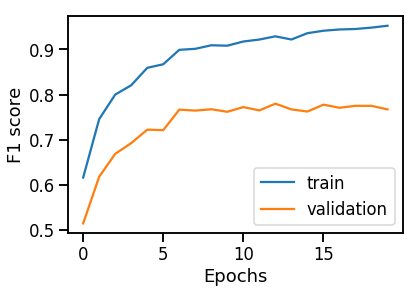

In [29]:
# Plot learning curves
fig, ax = plt.subplots()
ax.plot(range(len(f1s_train)), f1s_train, label='train')
ax.plot(range(len(f1s_train)), f2s_valid, label='validation')
ax.set_xlabel('Epochs')
ax.set_ylabel('F1 score')
ax.legend();

In [10]:
# Load the trained model
nlp = spacy.load('model/spaCy_dz_NER_20epochs')

In [11]:
print ('F1 score (train): %.4f' % evaluate_f1_for_spacy_model(data_train, nlp))
print ('F1 score (valid): %.4f' % evaluate_f1_for_spacy_model(data_valid, nlp))
print ('F1 score (test): %.4f' % evaluate_f1_for_spacy_model(data_test, nlp))

F1 score (train): 0.9526
F1 score (valid): 0.7672
F1 score (test): 0.7742


### Check the tagging results on training data 

In [12]:
doc = nlp(data_train[0][0])
displacy.render(doc, style='ent', jupyter=True)

In [13]:
display_truth(data_train[0])

### Check the tagging results on test data 

In [14]:
doc = nlp(data_test[0][0])
displacy.render(doc, style='ent', jupyter=True)

In [15]:
display_truth(data_test[0])

In [16]:
# Explore uncertain predictions
def get_ner_probas(nlp, text):
    '''
    To get the probability of the tagged ERs from the model.
    
    This is still an open issue: https://github.com/explosion/spaCy/issues/881
    '''
    with nlp.disable_pipes('ner'):
        doc = nlp(text)

    (beams, somethingelse) = nlp.entity.beam_parse([ doc ], beam_width = 16, beam_density = 0.0001)
    
    entity_scores = defaultdict(float)
    for beam in beams:
        for score, ents in nlp.entity.moves.get_beam_parses(beam):
            for start, end, label in ents:
                entity_scores[(doc[start:end].text, label, start, end)] += score
    df = pd.DataFrame.from_records(list(entity_scores.items()), 
                                             columns=['tuple', 'proba'])
    df['entity'] = df['tuple'].map(lambda x: x[0])
    df['entity_type'] = df['tuple'].map(lambda x:x[1])
    df['start'] = df['tuple'].map(lambda x:x[2])
    df['end'] = df['tuple'].map(lambda x:x[3])
    return df.drop('tuple', axis=1)

In [17]:
entity_scores = get_ner_probas(nlp, data_test[0][0])
entity_scores.sort_values('proba', ascending=False)

,proba,entity,entity_type,start,end
0,1.000000e+00,of the copper toxicosis,Modifier,2,6
5,1.000000e+00,WD,SpecificDisease,64,65
9,1.000000e+00,WD,SpecificDisease,198,199
7,1.000000e+00,autosomal recessive copper toxicosis,DiseaseClass,109,113
6,1.000000e+00,copper overload disease non-Indian childhood c...,DiseaseClass,92,100
8,1.000000e+00,WD,Modifier,136,137
3,1.000000e+00,an inherited disorder,DiseaseClass,33,36
2,1.000000e+00,Abnormal hepatic copper accumulation,DiseaseClass,26,30
1,9.899101e-01,in,DiseaseClass,15,16
4,5.346125e-01,Wilson disease,SpecificDisease,61,63


In [18]:
# test on a document from GEO
geo_text = '''
Primary tumor growth induces host tissue responses that are believed to support and promote tumor progression. Identification of the molecular characteristics of the tumor microenvironment and elucidation of its crosstalk with tumor cells may therefore be crucial for improving our understanding of the processes implicated in cancer progression, identifying potential therapeutic targets, and uncovering stromal gene expression signatures that may predict clinical outcome. A key issue to resolve, therefore, is whether the stromal response to tumor growth is largely a generic phenomenon, irrespective of the tumor type, or whether the response reflects tumor-specific properties. To address similarity or distinction of stromal gene expression changes during cancer progression, oligonucleotide-based Affymetrix microarray technology was used to compare the transcriptomes of laser-microdissected stromal cells derived from invasive human breast and prostate carcinoma. Invasive breast and prostate cancer-associated stroma was observed to display distinct transcriptomes, with a limited number of shared genes. Interestingly, both breast and prostate tumor-specific dysregulated stromal genes were observed to cluster breast and prostate cancer patients, respectively, into two distinct groups with statistically different clinical outcomes. By contrast, a gene signature that was common to the reactive stroma of both tumor types did not have survival predictive value. Univariate Cox analysis identified genes whose expression level was most strongly associated with patient survival. Taken together, these observations suggest that the tumor microenvironment displays distinct features according to the tumor type that provides survival-predictive value.
'''
doc = nlp(geo_text)
displacy.render(doc, style='ent', jupyter=True)

In [19]:
# Explore learned word vectors
tokens = nlp('disease cancer diabetes gene')
for token1 in tokens:
    for token2 in tokens:
        print(token1.text, token2.text, token1.similarity(token2))

disease disease 1.0
disease cancer 0.30716813
disease diabetes 0.3533679
disease gene -0.24855995
cancer disease 0.30716813
cancer cancer 1.0
cancer diabetes 0.49831825
cancer gene -0.16820928
diabetes disease 0.3533679
diabetes cancer 0.49831825
diabetes diabetes 1.0
diabetes gene -0.12104961
gene disease -0.24855995
gene cancer -0.16820928
gene diabetes -0.12104961
gene gene 1.0


In [20]:
token1.vector.shape

(128,)

# References:

- [Extracting Information from Text
](https://www.nltk.org/book/ch07.html)
- [Introduction to Named Entity Recognition with Examples and Python Code for training Machine Learning model](https://www.commonlounge.com/discussion/2662a77ddcde4102a16d5eb6fa2eff1e)
- [NER tutorial using conditional random field](https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html#let-s-use-conll-2002-data-to-build-a-ner-system)
- [Conditional Random Fields: Probabilistic Models for Segmenting and Labeling Sequence Data](https://dl.acm.org/citation.cfm?id=655813)
- [Neural Architectures for Named Entity Recognition](https://arxiv.org/abs/1603.01360) 